 # ShipSet Model Training

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import json
import glob
import PIL
import PIL.Image as Image
import tqdm
import time
import os
import random

import sklearn.model_selection

import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision
import matplotlib.pyplot as plt

# Config

In [2]:
N_FOLDS=5

TRAIN_BATCH_SIZE=4
TEST_BATCH_SIZE=4

CRITERION=torch.nn.CrossEntropyLoss()

EPOCHS=10

OPTIMIZER="SGD"
OPTIMIZER_PARAMS={"lr":0.01,"momentum":0.9}

USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

MODEL_SAVE_DIR="models"

EARLY_STOP=3 #after this many epochs, early stop if no improvement has happened
SEED=42

np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)

In [3]:
os.makedirs(MODEL_SAVE_DIR,exist_ok=True)

# Load Dataset

In [4]:
f = open("Data\shipsnet.json")
 
# returns JSON object as
# a dictionary
dataset = json.load(f)


In [5]:
Images=np.reshape(np.array(dataset['data']),(4000,3,80,80)).astype('uint8')


In [6]:
labels=np.array(dataset['labels'])

## Create Dataset

In [7]:
class ShipSet(Dataset):
    def __init__(self, images, labels, transform=None):
        """
        images: a np array of the images
        labels: the labels for each image
        transforms: the transforms used to transform each image, this will be necessary because the
        dataset is very small, only 4,000 images
        """
        self.images=torch.from_numpy(images)
        self.labels=labels
        self.transform=transform
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self,index):
        
        image=self.images[index]
        label=self.labels[index]
        
        if self.transform:
            image=self.transform(image)
        
        return image,label
        
        

As a test, lets have our custom dataset display some images, to do that let us write a function to display the images together as one matplotlib figure, this will also come in handy when we begin to experiment with transforms

In [8]:
def display_images(dataset, indexs):
    fig,axs=plt.subplots(ncols=len(indexs),figsize=(10,10*len(indexs)))
    
    for i, index in enumerate(indexs):
        image, label=dataset[index]
        axs[i].imshow(image.T.numpy())
        axs[i].axis('off')
        if label==1:
            axs[i].title.set_text("ship")
        else:
            axs[i].title.set_text("not ship")
        



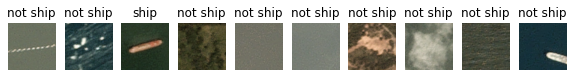

In [9]:
testSet=ShipSet(Images,labels)
display_images(testSet, np.random.choice(np.arange(len(testSet)),size=10))

# Writing the Train and Val Functions

In [10]:
def train_once(model,trainLoader,optimizer,
               criterion,device='cpu',
               print_loss=True,print_accuracy=True):
    
    start_time=time.time()
    total_loss=0
    n_correct=0
    n_total=0
    for batch in trainLoader:
        Images=batch[0].to(device)
        Labels=batch[1].to(device).long()
        #print(Labels)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(Images)
        loss = criterion(outputs, Labels)
        loss.backward()
        optimizer.step()
        
        #record loss and accuracy
        total_loss+=loss.item()
        n_correct=torch.sum(torch.argmax(outputs, axis=1)==Labels).item()
        n_total=Labels.shape[0]
    
    print(f"time:{round(time.time()-start_time,2)}s",end="|")
    if print_loss:
        print(f"train loss={round(total_loss/n_total,5)}",end="|")
    if print_accuracy:
        print(f"train accuracy={round(n_correct/n_total,4)}",end="|")
    

In [11]:
def val(model,valLoader,device="cpu"):
    
    label_true=[]
    label_pred=[]
    with torch.no_grad():
        for batch in valLoader:
            Images=batch[0].to(device)
            Labels=batch[1]
            # calculate outputs by running images through the network
            outputs = model(Images).cpu().detach()
            
            #record predictions and truths
            label_true+=Labels.tolist()
            label_pred+=torch.max(outputs.data, 1)[1].tolist()
    return label_true,label_pred

# Helper functions to create the model and optimizer

In [12]:
def create_model():
    model=torchvision.models.resnet18(pretrained=False)
    model.fc=torch.nn.Linear(512,2)
    return model

In [13]:
def create_optimizer(model,optimizer_name,optimizer_params):
    if optimizer_name=="SGD":
        return optim.SGD(model.parameters(),**optimizer_params)

# Create Transforms

Because the dataset is so small we will have to transform the dataset. To do this I will be using the transforms found in the torchvision.transforms library

In [14]:
transform=T.Compose([
    T.RandomRotation(180),
    T.ConvertImageDtype(torch.float32)
])

To understand how this would alter the images, let us plot a sample of untransformed and transformed images

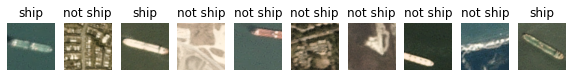

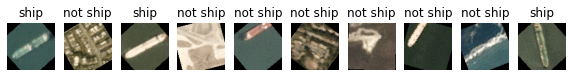

In [15]:
testSetTransfom=ShipSet(Images,labels,transform=transform)
indexs=np.random.choice(np.arange(len(testSet)),size=10)
display_images(testSet, indexs)
display_images(testSetTransfom, indexs)

# Main Routine

In [18]:
def main():
    kf = sklearn.model_selection.KFold(n_splits=N_FOLDS,shuffle=True)
    fold=1
    OOF_Accuracy=0
    all_labels_true=[]
    all_labels_pred=[]
    for train_index, test_index in kf.split(labels):
        print(f"----------fold {fold}----------")
        trainSet=ShipSet(Images[train_index],labels[train_index],transform=transform)
        valSet=ShipSet(Images[test_index],labels[test_index],
                      transform=T.ConvertImageDtype(torch.float32))
        
        
        trainLoader=DataLoader(trainSet, batch_size=TRAIN_BATCH_SIZE,shuffle=True)
        valLoader=DataLoader(valSet, batch_size=TEST_BATCH_SIZE)
        
        model=create_model()
        model.to(DEVICE)
        optimizer=create_optimizer(model,OPTIMIZER,OPTIMIZER_PARAMS)
        
        best_accuracy=0
        epochs_without_improvment=0
    
        
        
        for epoch in range(EPOCHS):
            print(f"epoch {epoch+1}",end=" ")
            train_once(model,trainLoader,optimizer,
               CRITERION,device=DEVICE)
            
            label_true,label_pred=val(model,valLoader,device=DEVICE)
            
            
            accuracy=sklearn.metrics.accuracy_score(label_true, label_pred)
            print(f"val accuracy={accuracy}")
            
            epochs_without_improvment+=1
            if accuracy>best_accuracy:
                best_accuracy=accuracy
                torch.save(model,f'{MODEL_SAVE_DIR}/fold{fold}.pt')
                epochs_without_improvment=0
                best_epoch=epoch+1
                best_pred_labels=label_pred
                
            if epochs_without_improvment==EARLY_STOP:
                print(f"early stopping because the val accuracy has not improved for {EARLY_STOP} epochs")
                break
        print(f"best val accuracy was {best_accuracy} on epoch {best_epoch}")
        OOF_Accuracy+=best_accuracy/N_FOLDS
        
        
        
        #plot out some example images from the val dataset:
        indexs=np.random.choice(np.arange(len(valSet)),size=10)
        fig,axs=plt.subplots(ncols=len(indexs),figsize=(5*len(indexs),5))
        for i,index in enumerate(indexs):
            image,correct_label=valSet[index]
            axs[i].imshow(image.T.numpy())
            correct="ship"
            if correct_label==0:
                correct="not ship"
            predicted="ship"
            if best_pred_labels[index]==0:
                predicted="not ship"
            
            axs[i].title.set_text(f"predicted: {predicted}\n ground truth: {correct}")
        plt.savefig(f"fold{fold}.png")
        plt.show()
        fold+=1
        
        all_labels_true+=label_true
        all_labels_pred+=best_pred_labels
    print(f"the OOF Accuracy was {OOF_Accuracy}")
    return all_labels_true,all_labels_pred
        
        
        
        
        
    

----------fold 1----------
epoch 1 time:16.81s|train loss=131.41442|train accuracy=0.75|val accuracy=0.89875
epoch 2 time:16.68s|train loss=30.79432|train accuracy=1.0|val accuracy=0.775
epoch 3 time:15.83s|train loss=35.20187|train accuracy=1.0|val accuracy=0.95
epoch 4 time:16.13s|train loss=18.31422|train accuracy=1.0|val accuracy=0.91875
epoch 5 time:17.66s|train loss=20.12569|train accuracy=1.0|val accuracy=0.9325
epoch 6 time:16.82s|train loss=14.19756|train accuracy=1.0|val accuracy=0.93
early stopping because the val accuracy has not improved for 3 epochs
best val accuracy was 0.95 on epoch 3


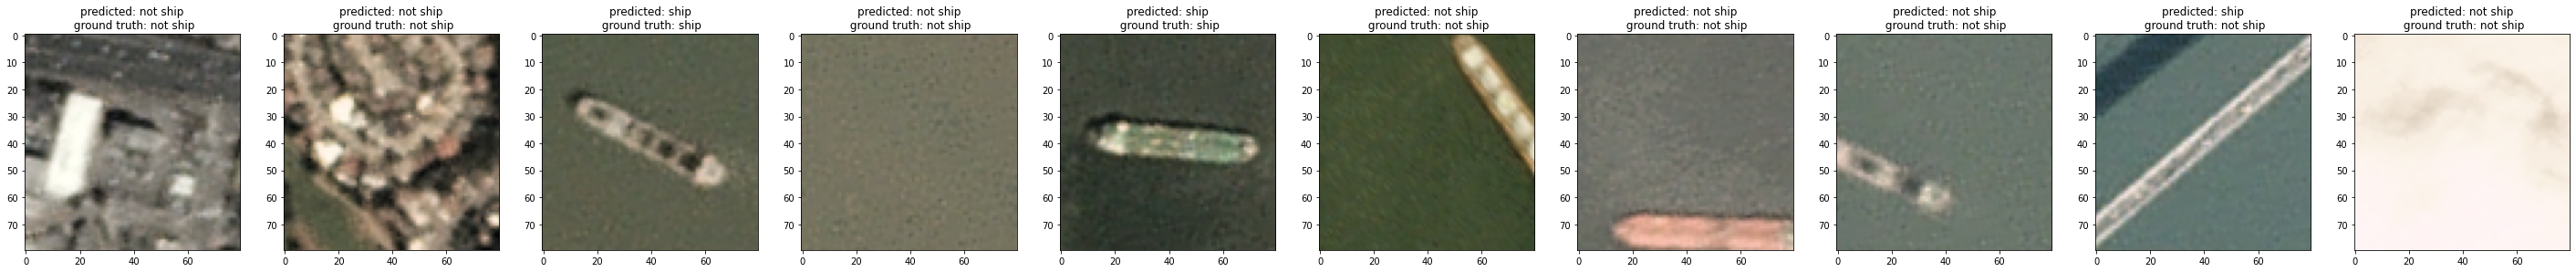

----------fold 2----------
epoch 1 time:17.48s|train loss=118.80737|train accuracy=1.0|val accuracy=0.81125
epoch 2 time:15.56s|train loss=47.12604|train accuracy=1.0|val accuracy=0.775
epoch 3 time:16.11s|train loss=35.02272|train accuracy=0.75|val accuracy=0.9575
epoch 4 time:15.08s|train loss=35.01902|train accuracy=0.75|val accuracy=0.9425
epoch 5 time:15.73s|train loss=20.61758|train accuracy=1.0|val accuracy=0.98875
epoch 6 time:16.32s|train loss=21.23626|train accuracy=1.0|val accuracy=0.9375
epoch 7 time:16.45s|train loss=16.30808|train accuracy=1.0|val accuracy=0.97
epoch 8 time:19.95s|train loss=16.53833|train accuracy=1.0|val accuracy=0.98125
early stopping because the val accuracy has not improved for 3 epochs
best val accuracy was 0.98875 on epoch 5


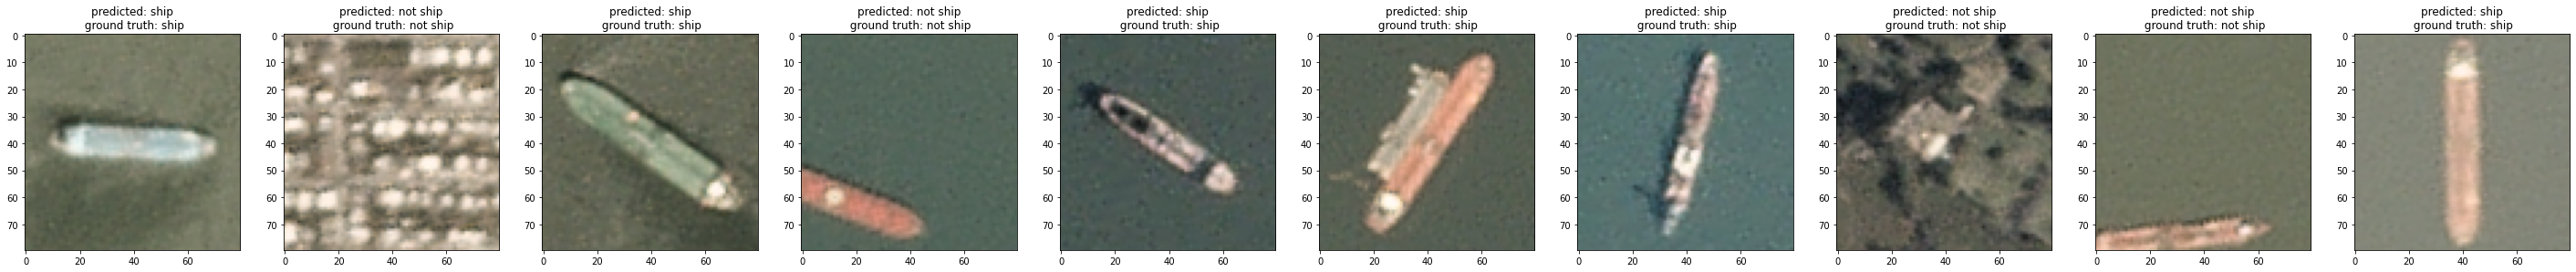

----------fold 3----------
epoch 1 time:18.09s|train loss=130.2789|train accuracy=1.0|val accuracy=0.85875
epoch 2 time:18.29s|train loss=44.82262|train accuracy=0.75|val accuracy=0.745
epoch 3 time:17.7s|train loss=27.93658|train accuracy=1.0|val accuracy=0.915
epoch 4 time:18.21s|train loss=30.5012|train accuracy=1.0|val accuracy=0.91375
epoch 5 time:18.08s|train loss=24.82809|train accuracy=1.0|val accuracy=0.8125
epoch 6 time:15.93s|train loss=21.44824|train accuracy=1.0|val accuracy=0.85125
early stopping because the val accuracy has not improved for 3 epochs
best val accuracy was 0.915 on epoch 3


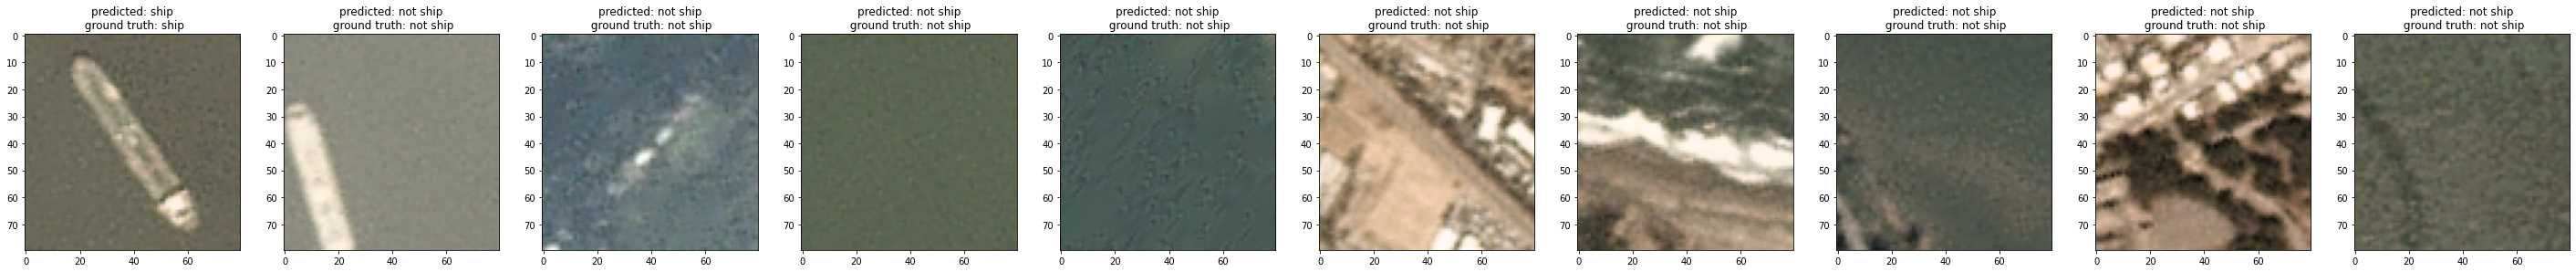

----------fold 4----------
epoch 1 time:14.21s|train loss=114.88781|train accuracy=1.0|val accuracy=0.83125
epoch 2 time:14.57s|train loss=42.67866|train accuracy=1.0|val accuracy=0.8725
epoch 3 time:13.77s|train loss=37.0891|train accuracy=1.0|val accuracy=0.85875
epoch 4 time:15.2s|train loss=34.86983|train accuracy=1.0|val accuracy=0.9425
epoch 5 time:14.23s|train loss=23.05193|train accuracy=1.0|val accuracy=0.7575
epoch 6 time:14.63s|train loss=24.05503|train accuracy=1.0|val accuracy=0.9375
epoch 7 time:14.07s|train loss=16.42329|train accuracy=1.0|val accuracy=0.86625
early stopping because the val accuracy has not improved for 3 epochs
best val accuracy was 0.9425 on epoch 4


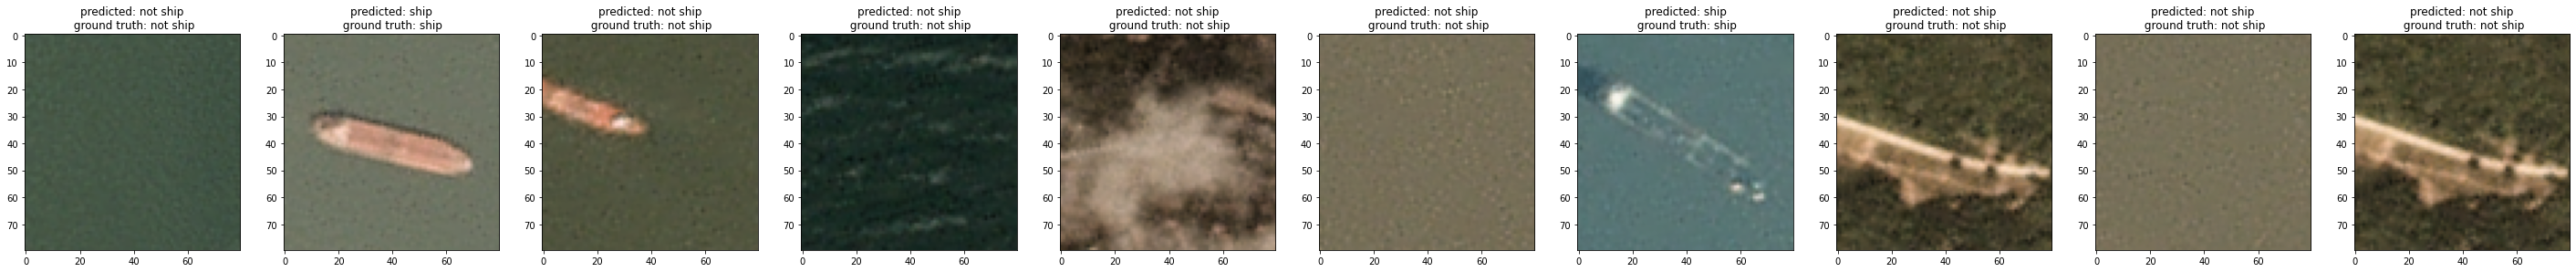

----------fold 5----------
epoch 1 time:14.62s|train loss=145.75424|train accuracy=1.0|val accuracy=0.77
epoch 2 time:14.45s|train loss=46.17724|train accuracy=1.0|val accuracy=0.82875
epoch 3 time:14.4s|train loss=35.09936|train accuracy=1.0|val accuracy=0.945
epoch 4 time:14.35s|train loss=23.3109|train accuracy=1.0|val accuracy=0.9375
epoch 5 time:14.43s|train loss=20.39407|train accuracy=1.0|val accuracy=0.975
epoch 6 time:14.06s|train loss=17.34288|train accuracy=1.0|val accuracy=0.9475
epoch 7 time:14.24s|train loss=16.38207|train accuracy=1.0|val accuracy=0.98125
epoch 8 time:14.06s|train loss=12.49995|train accuracy=1.0|val accuracy=0.945
epoch 9 time:13.83s|train loss=13.48412|train accuracy=1.0|val accuracy=0.9675
epoch 10 time:14.33s|train loss=11.05051|train accuracy=1.0|val accuracy=0.9625
early stopping because the val accuracy has not improved for 3 epochs
best val accuracy was 0.98125 on epoch 7


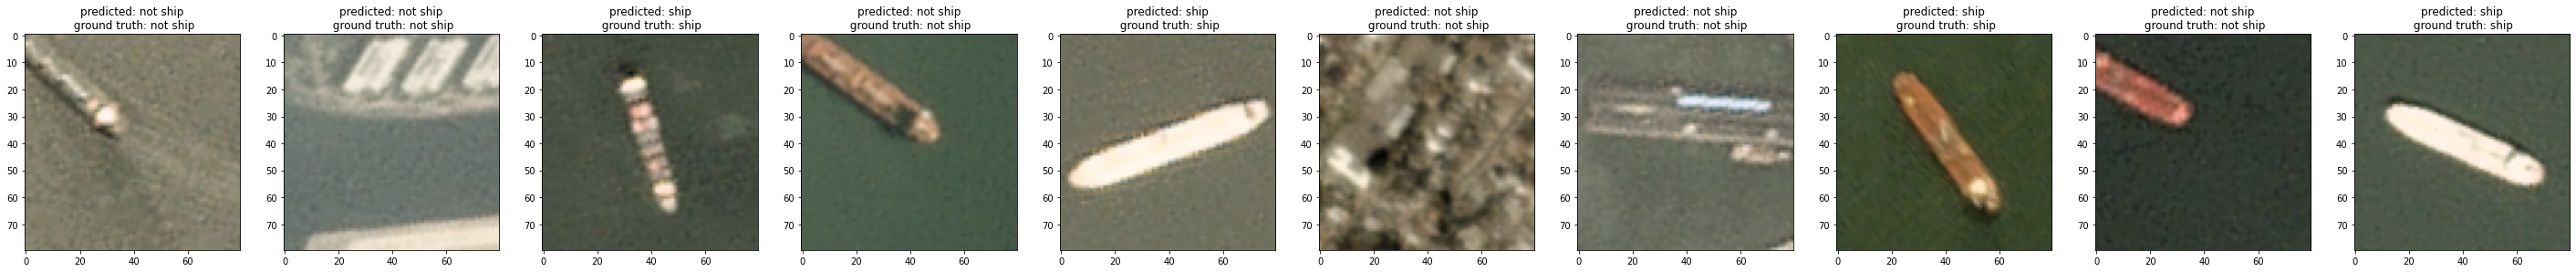

the OOF Accuracy was 0.9555


In [19]:
labels_true,labels_pred=main()

We can also plot out the confusion matrix for the out of fold predictions

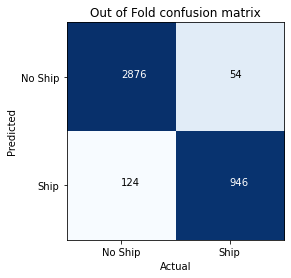

In [20]:
confusion_matrix=sklearn.metrics.confusion_matrix(labels_true,labels_pred)
plt.imshow(confusion_matrix/np.sum(confusion_matrix,axis=1),cmap='Blues')
for x in range(2):
    for y in range(2):
        color="black"
        if x==y:
            color="white"
        plt.text(x,y,confusion_matrix[x,y],color=color)

plt.xticks([0,1],["No Ship","Ship"])
plt.yticks([0,1],["No Ship","Ship"])
plt.ylabel("Predicted")
plt.xlabel("Actual")
plt.title("Out of Fold confusion matrix")
plt.savefig("ConfusionMatrix.png")
plt.show()